In [3]:
from datasets import load_dataset

Import the Dataset

In [4]:
dataset = load_dataset("json",data_files="economics.jsonl" , split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Formatting

In [5]:
def format_for_t5(example):
  instruction = example["instruction"]
  input_text = example.get("input","")
  return {
      "prompt": f"{instruction}\n{input_text}".strip(),
      "labels" : example["output"]
  }

In [6]:
formatted = dataset.map(format_for_t5)

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Import smolLM

In [7]:
model_name = "HuggingFaceTB/SmolLM2-360M"

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Tokenization

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [10]:
formatted

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels'],
    num_rows: 55
})

In [11]:
def tokenize(example):
    inputs = tokenizer(
        example["prompt"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    outputs = tokenizer(
        example["labels"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": outputs["input_ids"]
    }


In [12]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [13]:
tokenized_dataset = formatted.map(tokenize)

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 55
})

Splitting

In [15]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

train = tokenized_dataset["train"]
eval = tokenized_dataset["test"]

In [16]:
train

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 44
})

Setting up training Arguments and Trainer

In [17]:
from transformers import TrainingArguments

In [22]:
training_args = TrainingArguments(
    output_dir="./checkpoints-smollm",
    num_train_epochs = 5,
    per_device_train_batch_size=2,
    learning_rate=5e-4,
    weight_decay=0.01,
    save_steps=10,
    logging_dir=".logs",
    logging_steps=1,
    report_to='none'
)

In [23]:
from transformers import Trainer

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    tokenizer=tokenizer
)

/tmp/ipython-input-1957636794.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model Training

In [25]:
trainer.train()

Step,Training Loss
1,6.689800
2,6.307400
3,6.010300
4,5.415300
5,6.718800
6,4.612200
7,4.927600
8,6.771600
9,7.096000
10,5.796800


TrainOutput(global_step=110, training_loss=4.627181875163859, metrics={'train_runtime': 786.5117, 'train_samples_per_second': 0.28, 'train_steps_per_second': 0.14, 'total_flos': 53160763392000.0, 'train_loss': 4.627181875163859, 'epoch': 5.0})

Save the model

In [26]:
model.save_pretrained("my-smollm")
tokenizer.save_pretrained("my-smollm")

('my-smollm/tokenizer_config.json',
 'my-smollm/special_tokens_map.json',
 'my-smollm/vocab.json',
 'my-smollm/merges.txt',
 'my-smollm/added_tokens.json',
 'my-smollm/tokenizer.json')

Testing

In [27]:
from transformers import pipeline

pipe = pipeline("text-generation", model="my-smollm", tokenizer="my-smollm")

Device set to use cuda:0


In [28]:
pipe("Why do developed countries want developing countries to liberalise their trade and investment?")

[{'generated_text': 'Why do developed countries want developing countries to liberalise their trade and investment?, and on investment has on investment has. and to investment investment in, developing countries. investments.. investment on investments to the1n investment. to.0 to. investments, investment has investments. the., are that investment, of investing is countries of, countries0\\  ofI as., as on the that the is\\00 that andn of the and'}]

Visualize loss

In [29]:
logs = trainer.state.log_history

In [30]:
import matplotlib.pyplot as plt

steps = []
losses = []

for entry in logs:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])


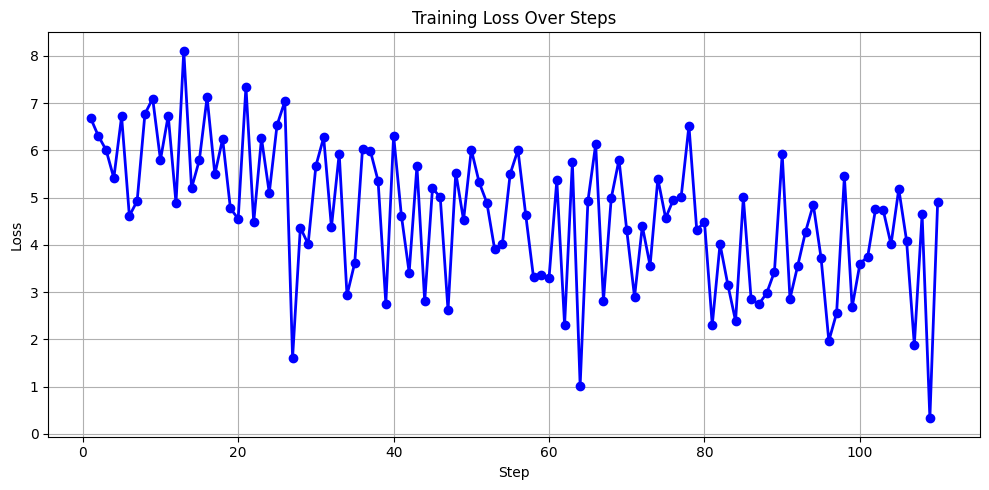

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', color='blue', linewidth=2)
plt.title("Training Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Download model

In [ ]:
#!zip -r my-smollm.zip my-smollm

In [ ]:
#from google.colab import files
#files.download("my-smollm.zip")